# Power-spectrum frequency clustering for anomaly detection

Reference:
###### Data Analytics for Managing Power in Commercial Buildings

GOWTHAM BELLALA, C3 IoT
MANISH MARWAH, MARTIN ARLITT, GEOFF LYON, CULLEN BASH, and AMIP SHAH,
Hewlett Packard Labs

In [45]:
import math
import numpy as np
import numpy.linalg as la
import pandas as pd
import power_utils
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import manifold
from scipy.fftpack import fft
from scipy import stats
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [46]:
train_loc = './tmp/train_prepared.csv'
test_loc = './input/submission_format.csv'
prediction_loc = './output/data_robot_gbm_diff_predictions.csv'
actual_colname = 'values_day_diff_7'
prediction_colname = 'Prediction'
prediction_cutoff = 0.7
output_note = 'gbm_diff_7'

### Import the prepared training set

In [47]:
train = pd.read_csv(train_loc, dtype={'meter_id': 'object', 'site_id': 'object'})

In [48]:
# Drop duplicates
train = train.drop_duplicates(['timestamp', 'meter_id'])

In [49]:
train.shape

(595833, 28)

### Subset
We will display one example based on meter_id = 2

In [50]:
subset = train.loc[train['meter_id'] == '2']

In [53]:
subset['date'] = pd.to_datetime(subset['timestamp']).dt.date;

D:\Users\Luis\Programs\Anaconda3\envs\PREDICT-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The clustering methodology works best on values aggregated by day. We can set the unit of time equal to anything we want, but that was not implemented here

In [54]:
subset_group = subset.groupby('date').sum().reset_index()

In [55]:
subset_group[['date', 'values']].head()

,date,values
0,2015-06-11,587.949
1,2015-06-12,681.681
2,2015-06-13,249.462
3,2015-06-14,270.407
4,2015-06-15,963.748


In [56]:
# Set DateTimeIndex based on the day group
subset_group['date'] = pd.to_datetime(subset_group['date'])
subset_group = subset_group.set_index('date')

In [58]:
subset_group['values'].head()

date
2015-06-11    587.949
2015-06-12    681.681
2015-06-13    249.462
2015-06-14    270.407
2015-06-15    963.748
Name: values, dtype: float64

### Compute fast Fourier transform in order to compute the frequency spectrum of the power-time curve


<img src="./imgs/fft.png">

In [59]:
y = fft(subset_group['values'].as_matrix())

In [60]:
y

array([  4.01482340e+05 +0.00000000e+00j,
         2.67883340e+04 +1.02264266e+04j,
         5.35262958e+04 +3.38892845e+03j,
        -6.90637479e+03 +1.17579514e+04j,
         1.41520124e+04 +2.68022645e+03j,
        -3.59288721e+04 +2.91326149e+03j,
        -1.01029427e+04 -2.55576008e+03j,
        -1.60701044e+04 -7.35507399e+03j,
        -1.28045560e+03 -2.05648911e+03j,
         1.23774636e+03 -8.73354927e+03j,
         2.37829546e+03 +3.52877708e+03j,
         1.85435822e+03 -3.12953311e+03j,
        -2.47995572e+03 +7.59334739e+03j,
        -7.04447018e+03 +5.07919942e+03j,
        -5.47060743e+03 +4.37697813e+03j,
        -1.21493736e+03 -2.87414746e+03j,
         2.89287834e+03 +2.57503593e+03j,
         1.03376963e+04 +1.60494770e+03j,
         9.44095469e+03 -2.39134183e+03j,
         1.21071668e+04 -3.50538857e+03j,
         2.20373317e+03 -1.69424179e+03j,
         7.01906495e+03 -1.83167303e+03j,
        -2.26508276e+03 +1.09003198e+03j,
         1.53591015e+03 +4.3276345

### Grab only the magnitude, drop the phase

In [61]:
x = np.absolute(y)

In [62]:
x

array([  4.01482340e+05,   2.86739366e+04,   5.36334707e+04,
         1.36362544e+04,   1.44035784e+04,   3.60467882e+04,
         1.04211977e+04,   1.76732954e+04,   2.42254288e+03,
         8.82082189e+03,   4.25541502e+03,   3.63766709e+03,
         7.98806015e+03,   8.68463165e+03,   7.00610329e+03,
         3.12038401e+03,   3.87292591e+03,   1.04615402e+04,
         9.73910372e+03,   1.26044134e+04,   2.77972933e+03,
         7.25412288e+03,   2.51371630e+03,   4.59210631e+03,
         1.03573766e+04,   6.78745789e+03,   4.64008725e+03,
         2.92236165e+03,   2.03415058e+03,   3.02414966e+03,
         5.99561670e+03,   1.87833261e+03,   3.33542925e+03,
         2.49382994e+03,   6.33315696e+03,   1.08854207e+04,
         8.99207733e+03,   7.31334654e+03,   1.43950109e+03,
         7.24905918e+03,   6.33854960e+03,   5.15291996e+03,
         6.89649704e+03,   1.95324405e+03,   2.07526293e+03,
         6.89325346e+03,   2.46246130e+03,   2.97128837e+03,
         3.81620684e+03,

### Compute dissimilarity matrix using Euclidean distance (linear algebra using the L2 norm)
<img src="./imgs/dissimilarity.png">

In [64]:
def compute_squared_EDM_method1(X):
    # determine dimensions of data matrix X
    m, n = X.shape
    # initialize squared EDM D
    D = np.zeros((n, n))
    # iterate over upper triangle of D
    for i in range(n):
        for j in range(i+1, n):
            D[i, j] = la.norm(X[:, i] - X[:, j])**2
            D[j, i] = D[i, j]
    return D

In [65]:
similarities = compute_squared_EDM_method1(np.asmatrix(x))

### Now we have an M x M matrix where M is the number of days being observed of the Euclidean distance between all frequency spectrum magnitudes

In [66]:
similarities

array([[  0.00000000e+00,   1.38986106e+11,   1.20998836e+11, ...,
          1.50424586e+11,   1.20998836e+11,   1.38986106e+11],
       [  1.38986106e+11,   0.00000000e+00,   6.22978345e+08, ...,
          2.26131886e+08,   6.22978345e+08,   0.00000000e+00],
       [  1.20998836e+11,   6.22978345e+08,   0.00000000e+00, ...,
          1.59977731e+09,   0.00000000e+00,   6.22978345e+08],
       ..., 
       [  1.50424586e+11,   2.26131886e+08,   1.59977731e+09, ...,
          0.00000000e+00,   1.59977731e+09,   2.26131886e+08],
       [  1.20998836e+11,   6.22978345e+08,   0.00000000e+00, ...,
          1.59977731e+09,   0.00000000e+00,   6.22978345e+08],
       [  1.38986106e+11,   0.00000000e+00,   6.22978345e+08, ...,
          2.26131886e+08,   6.22978345e+08,   0.00000000e+00]])

### In order to reduce the dimensionality of this matrix we can use manifold multidimensional scaling (MDS)
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

In [67]:
seed = 123
mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=3, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

### I used 3 dimensions because I will later use a clustering algorithm and it will require low-dimensional space due to the curse of dimensionality. 3 dimensions are also easier to plot.

In [68]:
npos

array([[  6.90651332e+00,  -7.69947142e+00,  -9.35524847e+00],
       [  2.66265768e-02,  -2.96902658e-02,  -3.59681844e-02],
       [  6.35597147e-02,  -7.08580392e-02,  -8.60848331e-02],
       ..., 
       [  4.86279862e-03,  -5.42356001e-03,  -6.54840389e-03],
       [  6.36066434e-02,  -7.09119421e-02,  -8.61205269e-02],
       [  2.64306770e-02,  -2.94677046e-02,  -3.57634019e-02]])

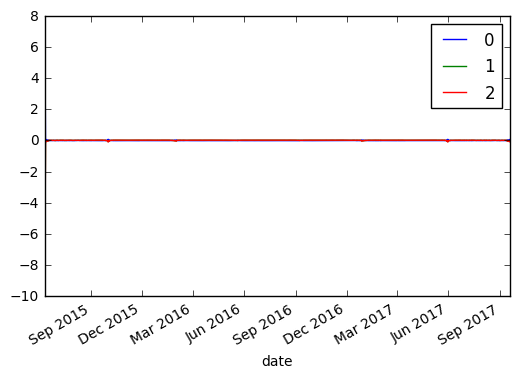

In [69]:
embeddings_df = pd.DataFrame(npos)
embeddings_df.index = subset_group.index
embeddings_df.plot()

In [70]:
x = embeddings_df.iloc[:, 0].as_matrix()
y = embeddings_df.iloc[:, 1].as_matrix()
z = embeddings_df.iloc[:, 2].as_matrix()
xyz = np.vstack([x, y, z])
kde = stats.gaussian_kde(xyz)
density = kde(xyz)

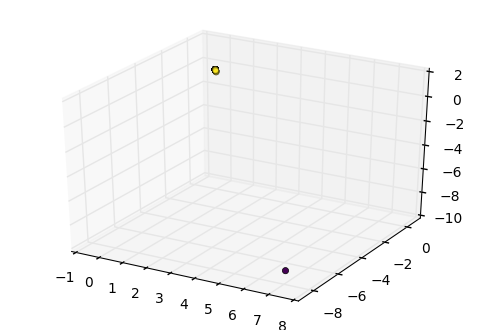

In [71]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

### Use kNN to determine whether these embeddings are anomalous or not
<img src="./tmp/figure2.gif">

In [73]:
M, d = embeddings_df.shape

### k is chosen based on the size of the matrix (number of days)

In [74]:
k = int(float(M)**(1/float(d)))

In [75]:
k

9

In [76]:
X = embeddings_df.iloc[:, 0:3]
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [77]:
distances

array([[  0.00000000e+00,   1.37980401e+01,   1.37980541e+01, ...,
          1.38707624e+01,   1.38762907e+01,   1.38763371e+01],
       [  0.00000000e+00,   3.60341657e-04,   2.17995758e-03, ...,
          1.33379987e-02,   1.33620332e-02,   1.40346173e-02],
       [  0.00000000e+00,   7.98865711e-05,   2.00193106e-02, ...,
          5.82173628e-02,   5.82638135e-02,   6.96075781e-02],
       ..., 
       [  0.00000000e+00,   1.84665901e-04,   3.10321877e-04, ...,
          2.82737065e-03,   3.15133505e-03,   3.56819696e-03],
       [  0.00000000e+00,   7.98865711e-05,   1.99423332e-02, ...,
          5.82943104e-02,   5.83407533e-02,   6.96845070e-02],
       [  0.00000000e+00,   3.60341657e-04,   2.53734177e-03, ...,
          1.29805952e-02,   1.30042910e-02,   1.36770522e-02]])

<img src="./imgs/knn.png">

In [78]:
R = distances.max(1)

In [79]:
fhat = k / ((4 * math.pi / 3) * R**3)

<img src="./imgs/prob.png">

In [89]:
prob = (fhat / np.max(fhat))

In [90]:
prob.min()

1.1377752542410543e-18

In [91]:
prob.max()

1.0

In [92]:
prob.mean()

0.031820058072816911

In [93]:
sum(x > 0.5 for x in prob)

8

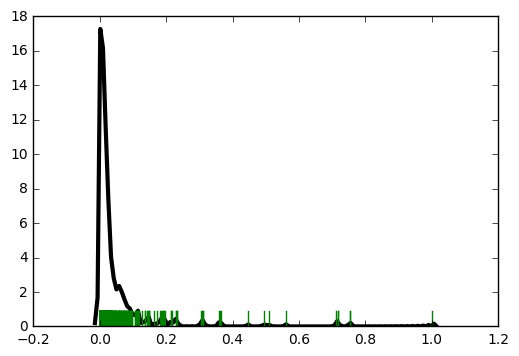

In [94]:
sns.distplot(prob, rug=True, hist=False, rug_kws={"color": "g"},
    kde_kws={"color": "k", "lw": 3})

In [95]:
subset_group['cluster_anomaly_probability'] = prob

In [96]:
subset_group[['values', 'cluster_anomaly_probability']].head()

,values,cluster_anomaly_probability
date,,
2015-06-11,587.949,1.137775e-18
2015-06-12,681.681,1.099713e-09
2015-06-13,249.462,9.013873e-12
2015-06-14,270.407,7.609441e-08
2015-06-15,963.748,1.815555e-07


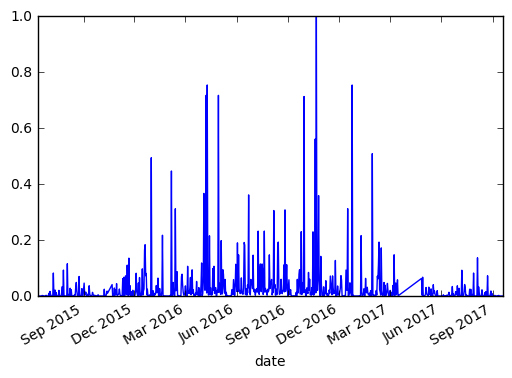

In [97]:
subset_group['cluster_anomaly_probability'].plot()

In [98]:
train.meter_id.unique()

array(['2', '234_203', '334_61', '38_9686', '863', '938'], dtype=object)